In [1]:
import pickle

In [2]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)


from ema_workbench import (Model, MultiprocessingEvaluator, Policy,
                           Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)

    dike_model, planning_steps = get_model_for_problem_formulation(0)

    # Build a user-defined scenario and policy:
    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'ID flood wave shape': 4, 'planning steps': 2}
    reference_values.update({f'discount rate {n}': 3.5 for n in planning_steps})
    scen1 = {}

    for key in dike_model.uncertainties:
        name_split = key.name.split('_')

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario('reference', **scen1)

    # no dike increase, no warning, none of the rfr
    zero_policy = {'DaysToThreat': 0}
    zero_policy.update({f'DikeIncrease {n}': 0 for n in planning_steps})
    zero_policy.update({f'RfR {n}': 0 for n in planning_steps})
    pol0 = {}

    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol0.update({key.name: zero_policy[s2]})

    policy0 = Policy('Policy 0', **pol0)



In [3]:
#sobol sampling, problem formulation 1
from ema_workbench import Samplers

dike_model, planning_steps = get_model_for_problem_formulation(1)





In [4]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
import pickle
use_pickle1 = True

if use_pickle1:
    with open('data/sensitivity_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    with MultiprocessingEvaluator(dike_model, n_processes=9) as evaluator: 
        results = evaluator.perform_experiments(scenarios=1200, policies=policy0, uncertainty_sampling=Samplers.SOBOL)

    # Save results in Pickle file
    with open('data/sensitivity_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

In [6]:
# Create a dataframe from outcomes
exp, outcomes = results


Expected Annual Damage


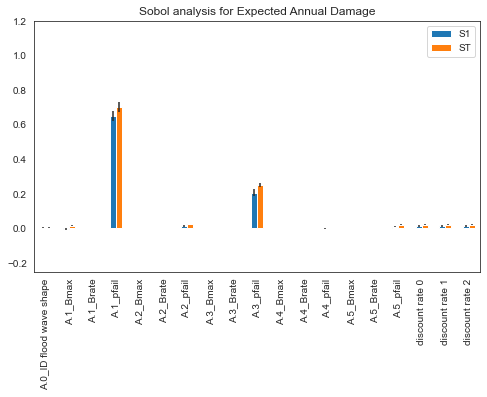

Expected Number of Deaths


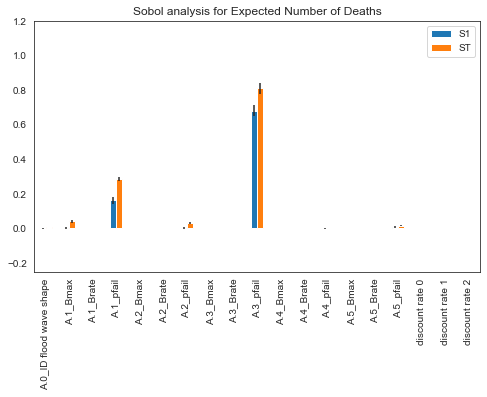

In [7]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#make dictionary of outcomes
sobol_df = pd.DataFrame.from_dict(outcomes)
sobol_df.drop('Total Investment Costs', inplace = True, axis =1) #take total investment costs out of outcomes

problem = get_SALib_problem(dike_model.uncertainties) #define a problem for Salib

#Apply the sobol analysis per outcome of interest and plot the results
for i in sobol_df.columns: 

    res = sobol_df[i].values
    Si = sobol.analyze(problem, res, calc_second_order=True, print_to_console = False)
    print(i)
    scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
    Si_df = pd.DataFrame(scores_filtered, index=problem["names"])


    sns.set_style("white")
    fig, ax = plt.subplots(1)

    indices = Si_df[["S1", "ST"]]
    err = Si_df[["S1_conf", "ST_conf"]]

    indices.plot.bar(yerr=err.values.T, ax=ax)
    ax.set_ylim(-0.25, 1.2)
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(bottom=0.3)
    plt.title('Sobol analysis for '+str(i))
    plt.savefig(f'sobolpolicy0_{i}')
    plt.show()
    


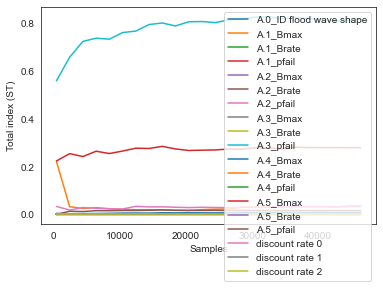

In [8]:
import numpy as np

Y =  sobol_df['Expected Number of Deaths'].values

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(10,1200,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']
    
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
plt.show()